# **Task 1: Adiabatic state preparation with Bloqade**

Question1: Generate the pulse/detuning sequence, specify the atomic position, then starting in the groundstate, simulate the time evolution of a quantum state under the Schrödinger equation. Plot the average occupation on each site as a function of time.

Question2: In addition, calculate the expectation value of $<σ^x_i>$ and gap $E_1-E_0=\Delta E $  between the Rydberg Hamiltonian's groundstate and first excited state. What does the latter imply about the viability of the adiabatic protocol for this type of quantum computer? Can you determine how it scales with increasing array size?

Solution1: We follow the solution already provided in the [tutorial](https://queracomputing.github.io/Bloqade.jl/dev/tutorials/2.adiabatic/main/#Preparation-of-Ordered-States-in-1D) for this question. First of all, we need to import the required libraries:

In [1]:
using Bloqade
using PythonCall
using KrylovKit
using SparseArrays
using LaTeXStrings
using Formatting

plt = pyimport("matplotlib.pyplot");

Next, we prepare the peicewise linear block of values for the Rabi frequency Ω and detuning parameter Δ.

In [2]:
# piecewise linear values for Rabi Frequency Ω
total_time = 3.0;
Ω_max = 2π * 4;
Ω = piecewise_linear(clocks = [0.0, 0.1, 2.1, 2.2, total_time], values = [0.0, Ω_max, Ω_max, 0, 0]); 

In [3]:
# piecewise linear values for detuning parameter Δ
U1 = -2π * 10;
U2 = 2π * 10;
Δ = piecewise_linear(clocks = [0.0, 0.6, 2.1, total_time], values = [U1, U1, U2, U2]);

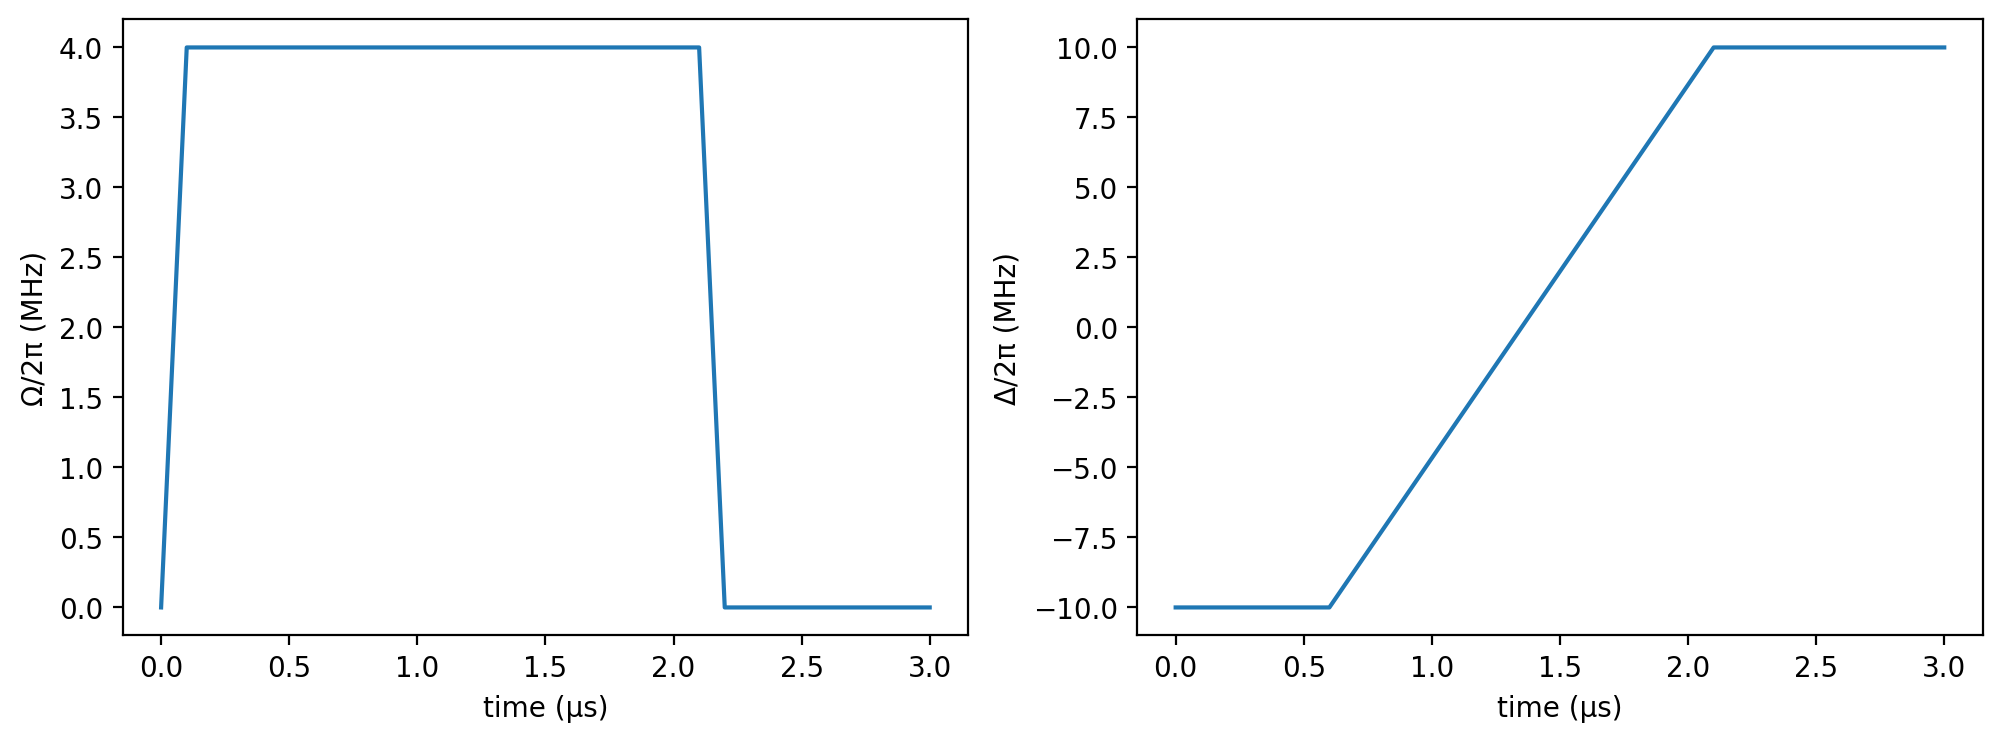

In [4]:
# plotting the two waveforms Ω and Δ
fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize = (12, 4))
Bloqade.plot!(ax1, Ω)
ax1.set_ylabel("Ω/2π (MHz)")
Bloqade.plot!(ax2, Δ)
ax2.set_ylabel("Δ/2π (MHz)")
fig

Next, we specify atomic positions separated by 5.72 μm and set up the Rydberg Hamiltonian for these atoms, and afterwards, evaluate the density of the sites based on time dependent evolution of the Schrodinger eqn solutions.

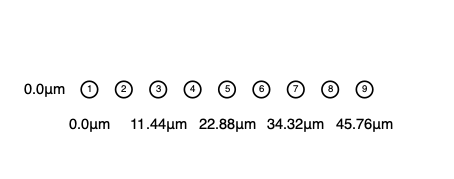

In [5]:
# specifying atomic positions separated by 5.72 μm
nsites = 9
atoms = generate_sites(ChainLattice(), nsites, scale = 5.72)

In [6]:
# generating the Rydberg hamiltonian
h = rydberg_h(atoms; Δ, Ω)

nqubits: 9
+
├─ [+] ∑ 2π ⋅ 8.627e6.0/|r_i-r_j|^6 n_i n_j
├─ [+] Ω(t) ⋅ ∑ σ^x_i
└─ [-] Δ(t) ⋅ ∑ n_i


Next, we evaluate time evolution of Hamiltonian from the Schrödinger equation, and the corresponding densities at individual atomic sites, expectation values $<\sigma^x_i>$  using Bloqade register, and energy gap between excited and ground state for every instanteous Hamiltonian $H(t)$ as $\Delta E = E_1 - E_0$.

In [14]:
# setting up emulation problem with ODE solver
reg = zero_state(nsites);
prob = SchrodingerProblem(reg, total_time, h);
integrator = init(prob, Vern8());

# using TimeChoiceIterator to specify time points to measure 'density' observable
densities = []
expect_sigmax = []
delta_E = []
time_series = 0.0:1e-2:total_time
for (u,t) in TimeChoiceIterator(integrator, time_series)
    push!(densities, rydberg_density(reg))
    for i in 1:nsites
        push!(expect_sigmax, expect(put(nsites,i=>X), reg))  
        # expectation of sigma_x at site i on state 'reg' of nsites
    end
end
D = hcat(densities...);
n_timeslots = size(D,2) 
expect_sigmax = reshape(expect_sigmax, (nsites,n_timeslots));

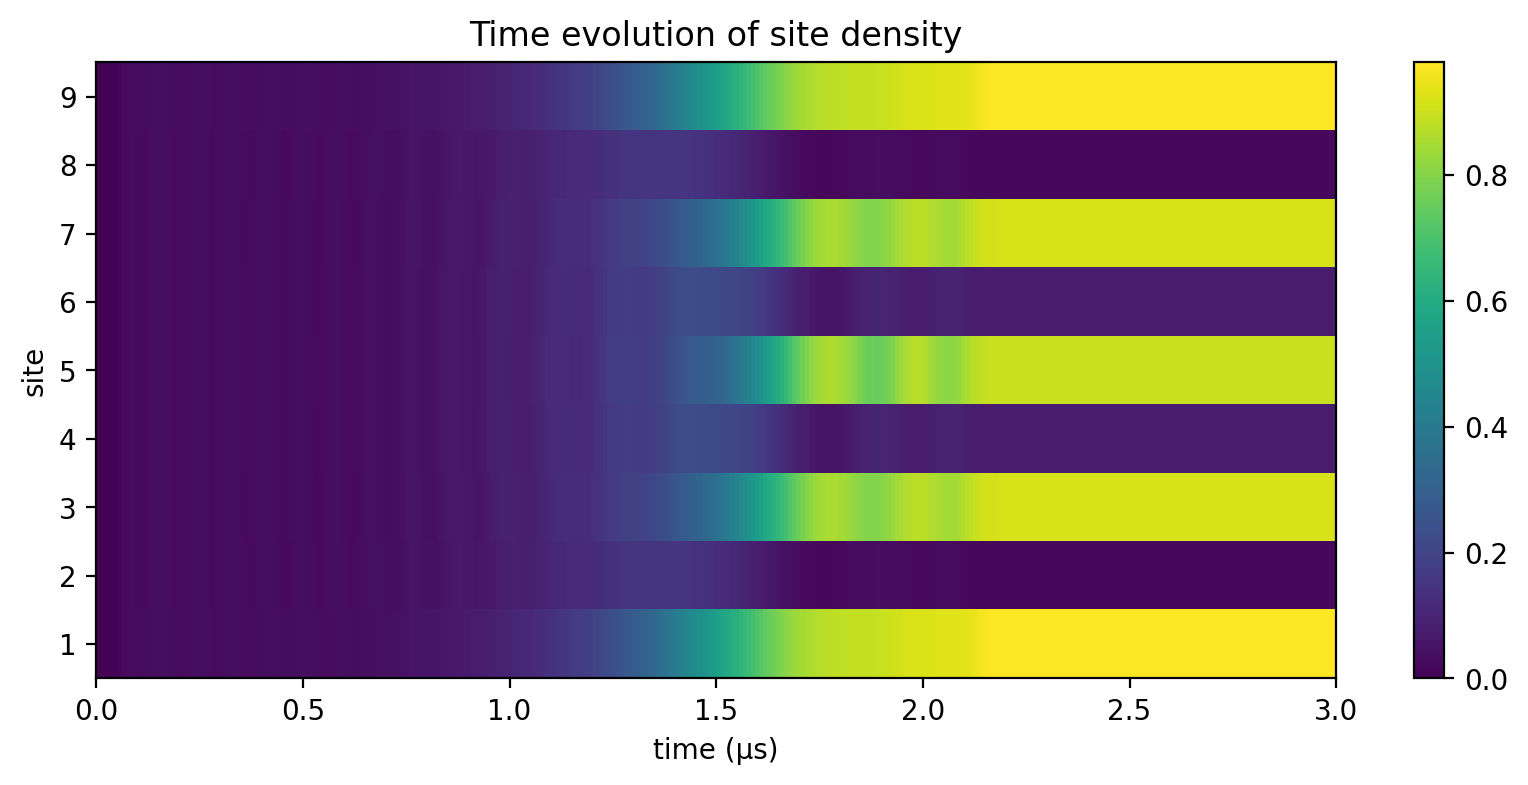

In [15]:
# plotting time dependent dynamics of Rydberg state's densities
fig, ax = plt.subplots(figsize = (10, 4))
shw = ax.imshow(real(D), interpolation = "nearest", aspect = "auto", extent = [0, total_time, 0.5, nsites + 0.5])
ax.set_xlabel("time (μs)")
ax.set_ylabel("site")
ax.set_xticks(0:0.5:total_time)
ax.set_yticks(1:nsites)
plt.title("Time evolution of site density")
bar = fig.colorbar(shw)
fig

As seen above, a 1D chain of Rydberg atoms in the $Z_2$ ordered state has been generated by the specified adiabatic pulse sequence. One can also visualize this by plotting the bitstring distribution at the final time step:

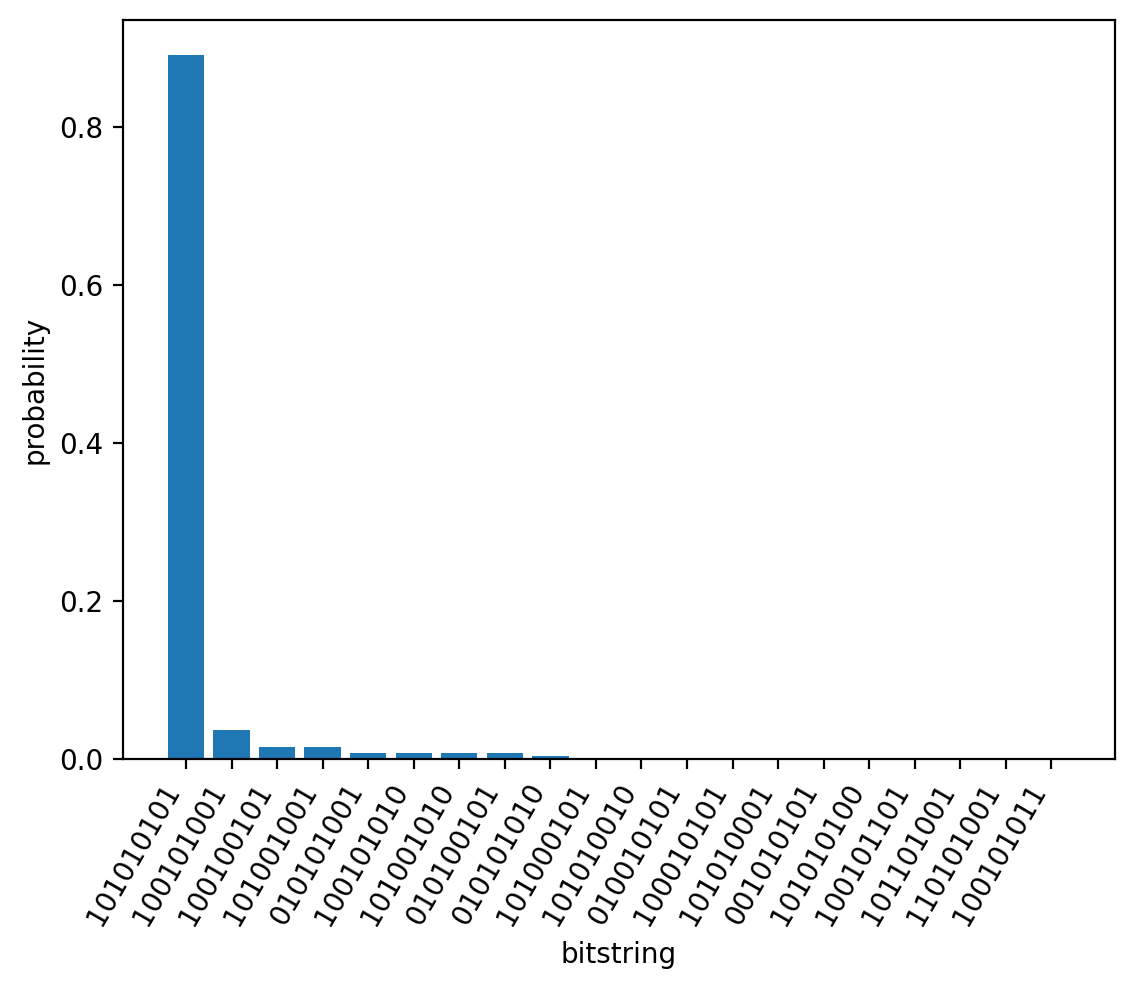

In [16]:
# viewing the final time step using wave function solutions in 'reg'
bitstring_hist(reg; nlargest = 20)

Solution2: We plot the evaluation of $<\sigma^x_i>$ and $\Delta E/E_0 $ from above

<σ^x_1> = -0.01 
<σ^x_2> = -0.00 
<σ^x_3> =  0.06 
<σ^x_4> = -0.00 
<σ^x_5> =  0.08 
<σ^x_6> = -0.00 
<σ^x_7> =  0.06 
<σ^x_8> = -0.00 
<σ^x_9> = -0.01 


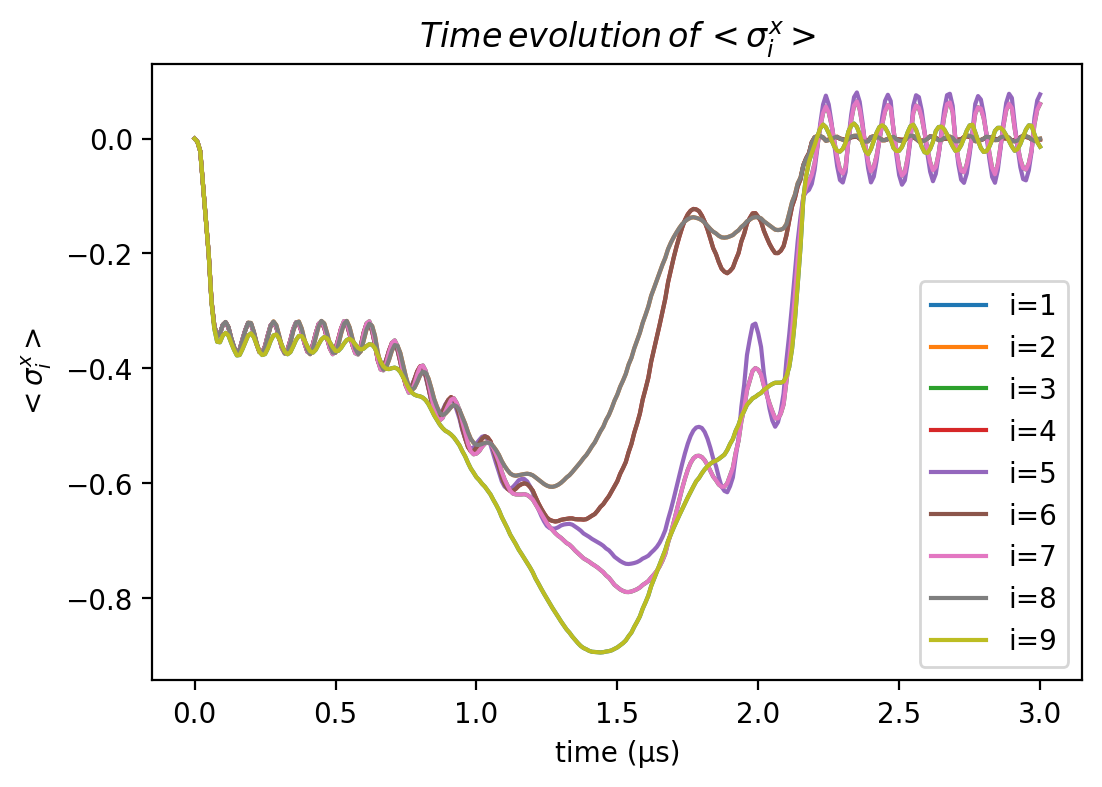

In [17]:
# plotting time dependent dynamics of <σ^x_i>
fig, ax1 = plt.subplots(ncols = 1, figsize = (6, 4))

# create a nsites X 1 grid, and map each of the nsites series to one of the subplots
for i in 1:nsites
    ax1.plot(time_series,real(expect_sigmax[i,:]),label="i="*string(i))
    printfmt("<σ^x_{:d}> = {:5.2f} \n" , i,real(expect_sigmax[i,end]))
end
ax1.legend()
ax1.set_ylabel(L"<σ^x_i>")
ax1.set_xlabel("time (μs)")
ax1.set_title(L"Time \, evolution \, of \, <σ^x_i>")
fig

Question3: How does $\Delta E$ scale with increasing array size?

Solution3: We start with evaluating $\Delta E$ from the last time step for a variety of array size in the following. Note that even number of atomic sites leads to degenerate ground states which means the energy gap vanishes for such cases. Hence we omit evaluation of even number of sites and only focus on the odd number of sites.  

In [24]:
delta_E_array = []
for nsites in 9:2:21
    # specifying atomic positions separated by 5.72 μm
    atoms = generate_sites(ChainLattice(), nsites, scale = 5.72)

    # generating the Rydberg hamiltonian
    h = rydberg_h(atoms; Δ, Ω)
    # Evaluating the Rydberg hamiltonian at end time t=total_time
    ht= h |> attime(total_time) 
    vals, vecs, info = KrylovKit.eigsolve(mat(ht), 2, :SR) # finding 2 smallest eigenvalues
    push!(delta_E_array, (vals[2]-vals[1] ) )      # evaluating (E_1-E_0)
    println("Nsites=" * string(nsites) * ": E_1-E_0="*string(vals[2]-vals[1] )*" MHz\n")
end

Nsites=9: E_1-E_0=55.895301855003396 MHz

Nsites=11: E_1-E_0=55.86410626677076 MHz

Nsites=13: E_1-E_0=55.840948421294456 MHz

Nsites=15: E_1-E_0=55.83849290286645 MHz

Nsites=17: E_1-E_0=55.8360374480564 MHz

Nsites=19: E_1-E_0=55.83462421186414 MHz

Nsites=21: E_1-E_0=55.83423302077438 MHz



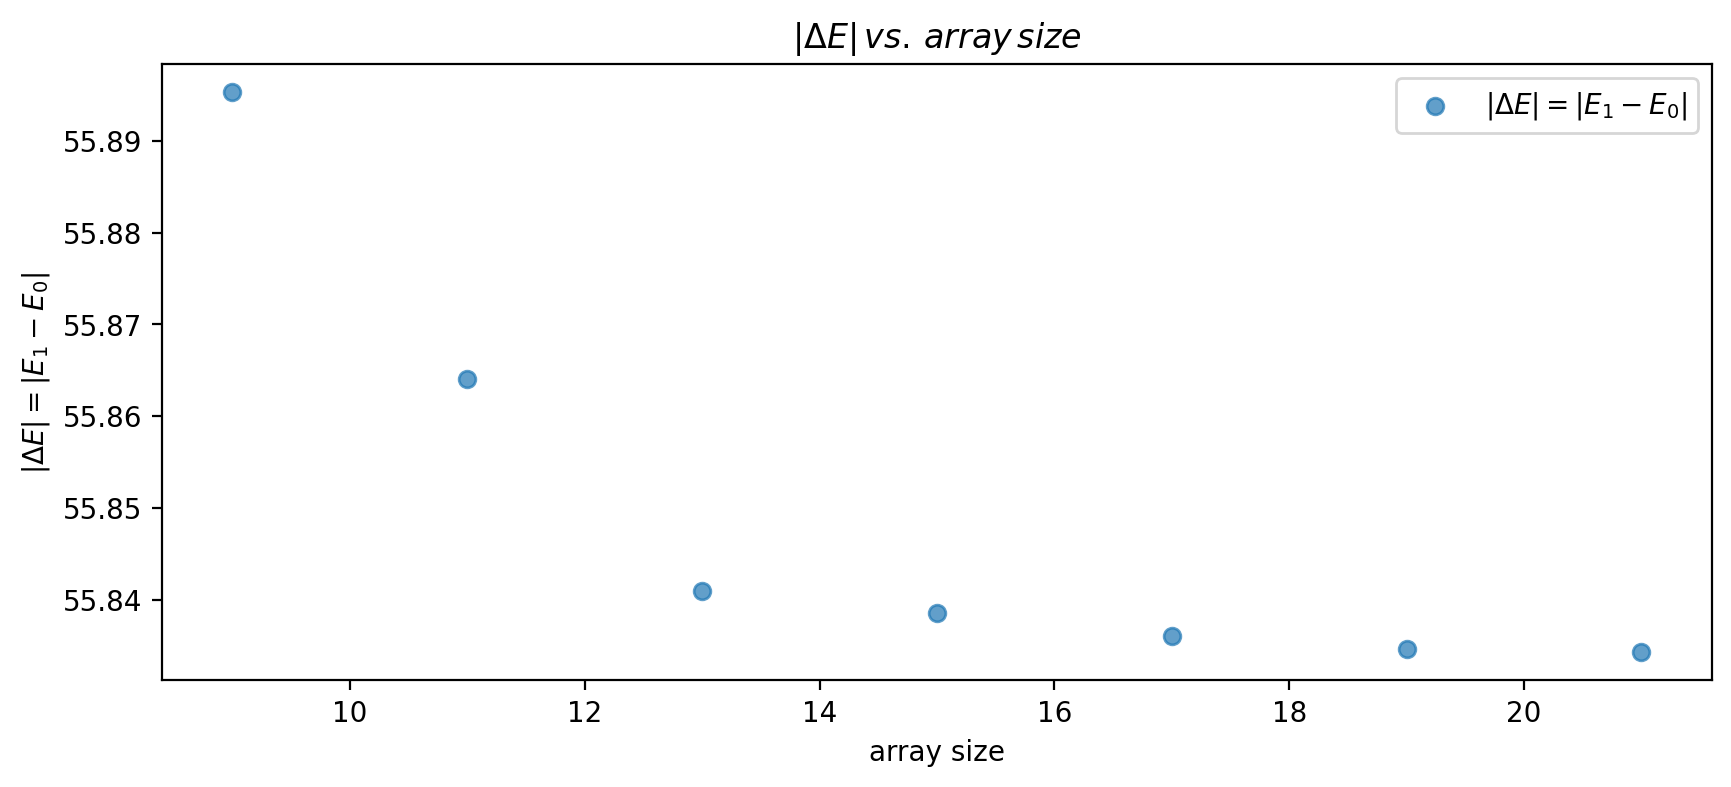

In [25]:
# plotting delta_E vs array size 
fig, ax = plt.subplots(figsize = (10, 4))
ax.scatter(9:2:21,abs.(delta_E_array),alpha=0.7, label=L"|\Delta E|=|E_1-E_0|")
ax.legend()
ax.set_ylabel(L"|\Delta E|=|E_1-E_0|")
ax.set_xlabel("array size")
ax.set_title(L"|\Delta E| \, vs. \, array \, size")

fig

As seen above, $\Delta E=E_1-E_0$ decreases upon increasing array size, however the rate of the derease becomes slower as we increase the number of qubits. For large array sizes the energy gap remains roughly the same. In terms of the viabilty, the energy gap is finite and stable, providing a two-level system with two distinguishable states. 